In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

In [7]:
# 데이터 불러오기
df = pd.read_csv('../data/무_월차낼게요.csv', encoding='cp949')
df_grow = pd.read_csv('../data/factor_external_weekly_ver_0721.csv', encoding='utf-8')

In [8]:
df['총거래량(kg)'] = np.log1p(df['총거래량(kg)'])

In [9]:
df.head()


,year,week,week_start,품종코드,등급코드,직팜산지코드,총거래량(kg),일평균기온,최고기온,최저기온,...,최저기온_t-2,평균상대습도_t-2,강수량(mm)_t-2,1시간최고강수량(mm)_t-2,일평균기온_t-3,최고기온_t-3,최저기온_t-3,평균상대습도_t-3,강수량(mm)_t-3,1시간최고강수량(mm)_t-3
0,2018,13,2018-03-26,100,11,1079,7.365813,16.800000,24.1,12.3,...,-6.550,52.208333,1.050,0.0,-0.685417,5.000,-5.525,72.120833,5.300,0.0
1,2018,13,2018-03-26,100,11,1137,9.261129,13.600000,17.6,9.4,...,0.975,62.008333,1.375,0.0,7.069048,12.675,3.300,71.919048,9.900,0.0
2,2018,13,2018-03-26,100,11,1170,6.398595,15.600000,19.3,12.0,...,0.550,57.207500,3.500,0.0,6.950000,11.250,3.175,69.987500,7.400,0.0
3,2018,13,2018-03-26,100,12,1000,8.692994,11.000000,18.1,5.3,...,-9.575,54.875000,1.750,0.0,-3.384821,3.275,-7.000,52.450893,1.050,0.0
4,2018,13,2018-03-26,100,12,1079,7.090910,14.333333,23.4,7.0,...,-5.875,55.605000,0.200,0.0,1.635000,7.225,-3.075,69.767500,8.275,0.0


In [10]:
# year, week 파생
def format_week_int(weekno):
    year = weekno // 100
    week = weekno % 100
    return year, week

df_grow[['year', 'week']] = df_grow['weekno'].apply(lambda x: pd.Series(format_week_int(x)))
df_grow.drop(columns='weekno', inplace=True)

# 병합 전 품목코드 추가
df['item_code'] = 1101

# 외생변수 병합
df = pd.merge(
    df,
    df_grow[['year', 'week', 'item_code', 'holiday_flag', 'holiday_score', 'grow_score']],
    on=['year', 'week', 'item_code'],
    how='left'
)

# 병합 후 외생변수 컬럼 재정의
for col in ['holiday_flag', 'holiday_score', 'grow_score']:
    if f"{col}_y" in df.columns:
        df[col] = df[f"{col}_y"]
        df.drop(columns=[f"{col}_x", f"{col}_y"], inplace=True)
df.drop(columns='item_code', inplace=True)

In [11]:
df.columns

Index(['year', 'week', 'week_start', '품종코드', '등급코드', '직팜산지코드', '총거래량(kg)',
       '일평균기온', '최고기온', '최저기온', '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)', '평균단가(원)',
       '일평균기온_t-1', '최고기온_t-1', '최저기온_t-1', '평균상대습도_t-1', '강수량(mm)_t-1',
       '1시간최고강수량(mm)_t-1', '일평균기온_t-2', '최고기온_t-2', '최저기온_t-2', '평균상대습도_t-2',
       '강수량(mm)_t-2', '1시간최고강수량(mm)_t-2', '일평균기온_t-3', '최고기온_t-3', '최저기온_t-3',
       '평균상대습도_t-3', '강수량(mm)_t-3', '1시간최고강수량(mm)_t-3', 'holiday_flag',
       'holiday_score', 'grow_score'],
      dtype='object')

In [12]:
# 0. 최소 연도 확인 (예: 2018)
min_year = df['year'].min()

# 1. 병합 대상 테이블 생성 (중복 제거 중요!)
price_lag = (
    df[['year', 'week', '직팜산지코드', '품종코드', '평균단가(원)']]
    .drop_duplicates(subset=['year', 'week', '직팜산지코드', '품종코드'])
    .copy()
)
price_lag['year'] += 1
price_lag = price_lag.rename(columns={'평균단가(원)': 'price_lag_1y'})

# 2. 병합 수행 (1:1 보장)
df = pd.merge(
    df,
    price_lag,
    on=['year', 'week', '직팜산지코드', '품종코드'],
    how='left'
)

# 3. 월 기준 평균단가로 보완
df['month'] = pd.to_datetime(df['week_start']).dt.month

monthly_avg = (
    df[['year', 'month', '직팜산지코드', '품종코드', '평균단가(원)']]
    .groupby(['year', 'month', '직팜산지코드', '품종코드'], as_index=False)
    .mean()
)

monthly_avg['year'] += 1
monthly_avg = monthly_avg.rename(columns={'평균단가(원)': 'price_lag_month_fill'})

df = pd.merge(
    df,
    monthly_avg,
    on=['year', 'month', '직팜산지코드', '품종코드'],
    how='left'
)

# 📌 월평균으로 보완 (단, 최소 연도는 제외)
df['price_lag_1y'] = df.apply(
    lambda row: row['price_lag_month_fill']
    if pd.isna(row['price_lag_1y']) and row['year'] > min_year
    else row['price_lag_1y'],
    axis=1
)

# 4. 연 평균으로 fallback
yearly_avg = (
    df[['year', '직팜산지코드', '품종코드', '평균단가(원)']]
    .groupby(['year', '직팜산지코드', '품종코드'], as_index=False)
    .mean()
)
yearly_avg['year'] += 1
yearly_avg = yearly_avg.rename(columns={'평균단가(원)': 'price_lag_fallback'})

df = pd.merge(
    df,
    yearly_avg,
    on=['year', '직팜산지코드', '품종코드'],
    how='left'
)

df['price_lag_1y'] = df.apply(
    lambda row: row['price_lag_fallback']
    if pd.isna(row['price_lag_1y']) and row['year'] > min_year
    else row['price_lag_1y'],
    axis=1
)
df.dropna(subset=['price_lag_1y'], inplace=True)

In [13]:
print("병합 후 행 수:", len(df))
print("NaN 비율:", df['price_lag_1y'].isna().mean())

병합 후 행 수: 74775
NaN 비율: 0.0


In [14]:
# df.sample(5)

In [15]:
print("남은 컬럼:\n", df.columns.tolist())


남은 컬럼:
 ['year', 'week', 'week_start', '품종코드', '등급코드', '직팜산지코드', '총거래량(kg)', '일평균기온', '최고기온', '최저기온', '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)', '평균단가(원)', '일평균기온_t-1', '최고기온_t-1', '최저기온_t-1', '평균상대습도_t-1', '강수량(mm)_t-1', '1시간최고강수량(mm)_t-1', '일평균기온_t-2', '최고기온_t-2', '최저기온_t-2', '평균상대습도_t-2', '강수량(mm)_t-2', '1시간최고강수량(mm)_t-2', '일평균기온_t-3', '최고기온_t-3', '최저기온_t-3', '평균상대습도_t-3', '강수량(mm)_t-3', '1시간최고강수량(mm)_t-3', 'holiday_flag', 'holiday_score', 'grow_score', 'price_lag_1y', 'month', 'price_lag_month_fill', 'price_lag_fallback']


In [16]:
# y, X 분리
y = df['평균단가(원)']
X = df.drop(columns=['평균단가(원)'])

In [17]:
def generate_moving_averages_fixed(df, target_col='평균단가(원)', group_cols=['직팜산지코드', '품종코드'], windows=[4, 13, 26]):
    """
    데이터 누수를 방지하고 이동평균 피처를 생성하는 수정된 함수
    """
    df = df.sort_values(group_cols + ['year', 'week']).copy()

    # 1. 그룹별로 target 값을 shift하여 임시 컬럼 생성 (데이터 누수 방지)
    df['shifted_target'] = df.groupby(group_cols)[target_col].shift(1)

    # 2. shift된 컬럼을 기준으로 이동 통계 피처 계산
    for w in windows:
        df[f'SMA_{w}'] = df.groupby(group_cols)['shifted_target'].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean()
        )
        df[f'EMA_{w}'] = df.groupby(group_cols)['shifted_target'].transform(
            lambda x: x.ewm(span=w, adjust=False).mean()
        )

    # 3. 위에서 계산된 EMA 피처를 기반으로 파생 변수 생성
    df['EMA4_SMA4_diff'] = df['EMA_4'] - df['SMA_4']
    df['EMA13_SMA13_diff'] = df['EMA_13'] - df['SMA_13']
    df['EMA26_SMA26_diff'] = df['EMA_26'] - df['SMA_26']

    df['EMA_4_rate'] = df.groupby(group_cols)['EMA_4'].transform(lambda x: x.pct_change().fillna(0))
    df['EMA_13_rate'] = df.groupby(group_cols)['EMA_13'].transform(lambda x: x.pct_change().fillna(0))
    df['EMA_26_rate'] = df.groupby(group_cols)['EMA_26'].transform(lambda x: x.pct_change().fillna(0))

    # 4. 임시로 사용한 컬럼 제거
    df = df.drop(columns=['shifted_target'])

    return df

# 수정된 함수를 호출합니다.
df_fixed = generate_moving_averages_fixed(df)

moving_avg_cols = [
    'SMA_4', 'SMA_13', 'SMA_26',
    'EMA_4', 'EMA_13', 'EMA_26',
    'EMA4_SMA4_diff', 'EMA13_SMA13_diff', 'EMA26_SMA26_diff',
    'EMA_4_rate', 'EMA_13_rate', 'EMA_26_rate', 'holiday_flag',
    'holiday_score', 'grow_score', 'price_lag_1y'
]

# df_final 이라는 새 변수에 결측값이 제거된 최종 데이터를 저장
df = df_fixed.dropna(subset=moving_avg_cols).copy()

# 1. 단기 시차(Lag) 피처 추가
print("단기 시차 피처를 추가합니다...")

# 그룹별(산지-품종)로 이전 1주, 2주, 3주차의 단가를 가져옵니다.
group_cols = ['직팜산지코드', '품종코드']
lags = [1, 2, 3]

for lag in lags:
    col_name = f'price_lag_{lag}w' # 컬럼 이름 예: price_lag_1w
    df[col_name] = df.groupby(group_cols)['평균단가(원)'].shift(lag)
    print(f"'{col_name}' 피처 생성 완료.")

# 2. 시차 피처 생성 후 생긴 결측값(NaN) 처리
# 각 그룹의 맨 앞부분에는 이전 데이터가 없어 NaN이 발생합니다.
# 이 행들은 모델 학습에 사용할 수 없으므로 제거합니다.
print("\\n시차 피처 생성으로 인해 발생한 결측값을 제거합니다...")
original_rows = len(df)
df.dropna(inplace=True) # 모든 NaN을 가진 행을 제거
new_rows = len(df)
print(f"{original_rows - new_rows}개의 행이 제거되었습니다.")

# 3. 추가된 피처 확인
print("\n추가된 시차 피처 확인:")
print(df[['year', 'week', '평균단가(원)', 'price_lag_1w', 'price_lag_2w', 'price_lag_3w']].head())


C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['EMA_4_rate'] = df.groupby(group_cols)['EMA_4'].transform(lambda x: x.pct_change().fillna(0))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['EMA_13_rate'] = df.groupby(group_cols)['EMA_13'].transform(lambda x: x.pct_change().fillna(0))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future v

단기 시차 피처를 추가합니다...
'price_lag_1w' 피처 생성 완료.
'price_lag_2w' 피처 생성 완료.
'price_lag_3w' 피처 생성 완료.
\n시차 피처 생성으로 인해 발생한 결측값을 제거합니다...
11620개의 행이 제거되었습니다.

추가된 시차 피처 확인:
       year  week  평균단가(원)  price_lag_1w  price_lag_2w  price_lag_3w
12108  2019    18    655.0         516.0         554.0         509.0
12115  2019    18    386.0         655.0         516.0         554.0
12258  2019    19    516.0         386.0         655.0         516.0
12269  2019    19    455.0         516.0         386.0         655.0
12447  2019    20    478.0         455.0         516.0         386.0


In [18]:

# 4주간의 가격 변동성(표준편차) 피처 생성
df['price_roll_std_4w'] = df.groupby(['직팜산지코드', '품종코드'])['price_lag_1w'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std()
)

# 결측값 처리
df.fillna(0, inplace=True)

In [19]:
# 모델 학습용 재분리 및 주기형 변수 처리
y = df['평균단가(원)']
X = df.drop(columns=['평균단가(원)'])

# ✅ 여기서 제거하는 게 베스트!
X = X.drop(columns=[
    '등급코드', '일평균기온', '최고기온', '최저기온',
    '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)',
    'month', 'price_lag_month_fill', 'price_lag_fallback'
], errors='ignore')

X['week_start'] = pd.to_datetime(X['week_start'])
X['year'] = X['week_start'].dt.year
X['week'] = X['week_start'].dt.isocalendar().week.astype(int)

X['week_sin'] = np.sin(2 * np.pi * X['week'] / 52)
X['week_cos'] = np.cos(2 * np.pi * X['week'] / 52)
X = X.drop(columns=['week'])


In [20]:
X_train = X[X['year'] < 2025].drop(columns=['week_start'])
y_train = y[X['year'] < 2025]
X_test = X[X['year'] == 2025].drop(columns=['week_start'])
y_test = y[X['year'] == 2025]


In [21]:
from sklearn.preprocessing import RobustScaler

exclude_cols = ['year', '품종코드', '직팜산지코드']  # 범주형 및 예외
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
scale_cols = [col for col in numerical_cols if col not in exclude_cols]

scaler = RobustScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [22]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['직팜산지코드', '품종코드']

for col in cat_cols:
    le = LabelEncoder()
    # 훈련 데이터로 인코더 학습 및 변환
    X_train[col] = le.fit_transform(X_train[col])
    
    # 딕셔너리를 사용해 알려진 라벨만 매핑하는 mapping 생성
    mapping = {label: i for i, label in enumerate(le.classes_)}
    
    # 시험 데이터 변환:
    # .map(mapping) -> 알려진 라벨은 숫자로 변환하고, 모르는 라벨(unseen)은 NaN으로 만듦
    # .fillna(-1)   -> NaN으로 바뀐 모르는 라벨들을 -1로 채움
    X_test[col] = X_test[col].map(mapping).fillna(-1).astype(int)

    print(f"'{col}' 인코딩 완료. 테스트 데이터의 새로운 라벨은 -1로 처리되었습니다.")

'직팜산지코드' 인코딩 완료. 테스트 데이터의 새로운 라벨은 -1로 처리되었습니다.
'품종코드' 인코딩 완료. 테스트 데이터의 새로운 라벨은 -1로 처리되었습니다.


In [23]:
# df.sample(5)
X_train.isna().sum(), X_test.isna().sum()
# train_df.info()
# test_df.info()

(year                 0
 품종코드                 0
 직팜산지코드               0
 총거래량(kg)             0
 일평균기온_t-1            0
 최고기온_t-1             0
 최저기온_t-1             0
 평균상대습도_t-1           0
 강수량(mm)_t-1          0
 1시간최고강수량(mm)_t-1     0
 일평균기온_t-2            0
 최고기온_t-2             0
 최저기온_t-2             0
 평균상대습도_t-2           0
 강수량(mm)_t-2          0
 1시간최고강수량(mm)_t-2     0
 일평균기온_t-3            0
 최고기온_t-3             0
 최저기온_t-3             0
 평균상대습도_t-3           0
 강수량(mm)_t-3          0
 1시간최고강수량(mm)_t-3     0
 holiday_flag         0
 holiday_score        0
 grow_score           0
 price_lag_1y         0
 SMA_4                0
 EMA_4                0
 SMA_13               0
 EMA_13               0
 SMA_26               0
 EMA_26               0
 EMA4_SMA4_diff       0
 EMA13_SMA13_diff     0
 EMA26_SMA26_diff     0
 EMA_4_rate           0
 EMA_13_rate          0
 EMA_26_rate          0
 price_lag_1w         0
 price_lag_2w         0
 price_lag_3w         0
 price_roll_std_

In [24]:
# 1. 필요한 라이브러리 임포트
import optuna
from lightgbm import LGBMRegressor # LGBMRegressor로 변경
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
# ---------------------------------------------------------------------------

# 2. 최적화 목표(Objective) 함수 정의
def objective(trial):
    """Optuna가 최적의 하이퍼파라미터를 찾기 위해 호출하는 함수"""
    # LGBMRegressor에 맞는 하이퍼파라미터 탐색 범위 지정
    params = {
        'objective': 'regression', # 회귀 문제임을 명시
        'metric': 'rmse', # 평가 지표를 RMSE로 설정
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0), # L1 정규화
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0), # L2 정규화
        'random_state': 42,
        'n_jobs': -1,
        'boosting_type': 'gbdt', # 일반적인 그래디언트 부스팅
    }

    # 모델 생성
    model = LGBMRegressor(**params) # LGBMRegressor로 변경

    # TimeSeriesSplit 객체 생성
    tscv = TimeSeriesSplit(n_splits=3)

    # 교차 검증의 cv 인자에 TimeSeriesSplit 객체를 전달합니다.
    rmse_scorer = make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred)))
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_scorer)

    return scores.mean()

# ---------------------------------------------------------------------------

# 3. Optuna Study 생성 및 최적화 실행
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20, n_jobs=-1)

# ---------------------------------------------------------------------------

# 4. 최적 결과 확인
print("탐색 완료!")
print(f"총 시도 횟수: {len(study.trials)}")
print("최적의 하이퍼파라미터:", study.best_params)
print(f"최적의 RMSE 값: {-study.best_value:.4f}")

# ---------------------------------------------------------------------------

# 5. 최적의 하이퍼파라미터로 최종 모델 학습 및 예측
best_params = study.best_params
# LGBMRegressor를 위한 추가 파라미터 설정 (random_state, n_jobs 등)
model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("\n최종 모델 예측 결과 (일부):", pred[:5])

c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-25 10:44:19,336] A new study created in memory with name: no-name-b456fda3-d538-43f6-8db6-3300545cc645
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\2170934170.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\2170934170.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest

탐색 완료!
총 시도 횟수: 20
최적의 하이퍼파라미터: {'n_estimators': 754, 'learning_rate': 0.010446307318214738, 'num_leaves': 215, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.7801040005097066, 'colsample_bytree': 0.6624344155163319, 'reg_alpha': 0.09150298757835852, 'reg_lambda': 3.789219092514882e-08}
최적의 RMSE 값: 212.5729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9476
[LightGBM] [Info] Number of data points in the train set: 60325, number of used features: 44
[LightGBM] [Info] Start training from score 538.885288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [29]:
# ✅ 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred) * 100  # %
nmae = (mae / np.mean(y_test)) * 100  # %

r2 = r2_score(y_test, pred)

# ✅ 출력
print("\n🏁 모델 성능:")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📊 MAE : {mae:.2f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📈 R²   : {r2:.4f}")
print(f"NMAE: {nmae:.4f}%")


🏁 모델 성능:
📉 RMSE: 345.99
📊 MAE : 281.44
📊 MAPE: 41.22%
📈 R²   : 0.2033
NMAE: 29.6472%


In [26]:
# 중요도 추출
importances = model.feature_importances_
feature_names = X_train.columns

# Series로 보기 좋게
import pandas as pd
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 출력
print("\n🔍 변수 중요도 Top 10")
print(feat_importance.head(10))


🔍 변수 중요도 Top 10
총거래량(kg)        6363
week_sin        6129
price_lag_2w    5874
week_cos        5758
year            5226
직팜산지코드          4994
price_lag_1y    4899
price_lag_1w    4876
강수량(mm)_t-2     4582
강수량(mm)_t-1     4560
dtype: int32


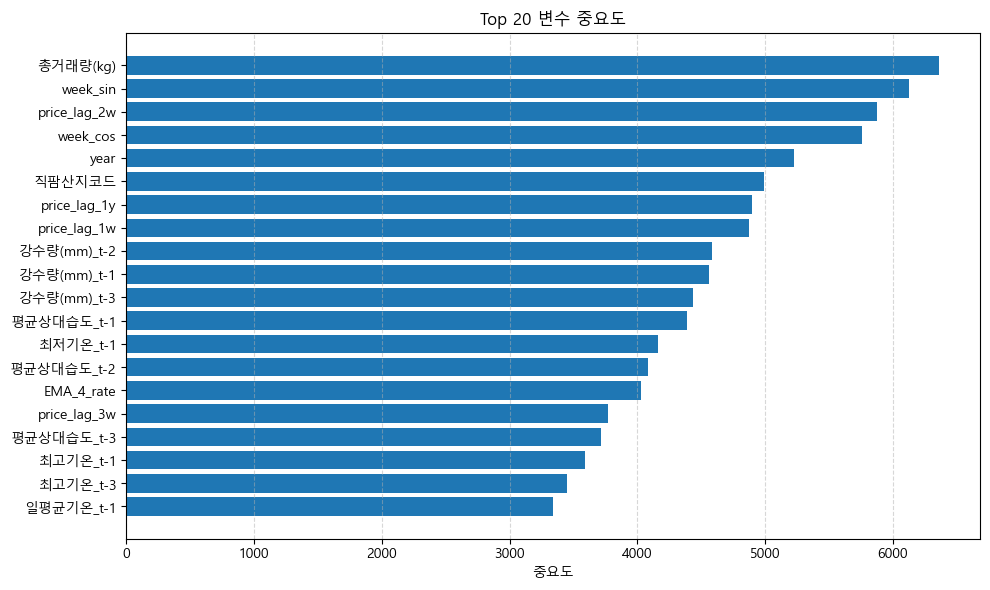

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ✅ 1. 변수 중요도 추출 (Gain 기준)

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_  # ✅ LightGBM이든 RF든 OK
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 시각화
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"][:top_n][::-1], importance_df["importance"][:top_n][::-1])
plt.xlabel("중요도")
plt.title(f"Top {top_n} 변수 중요도")
plt.tight_layout()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


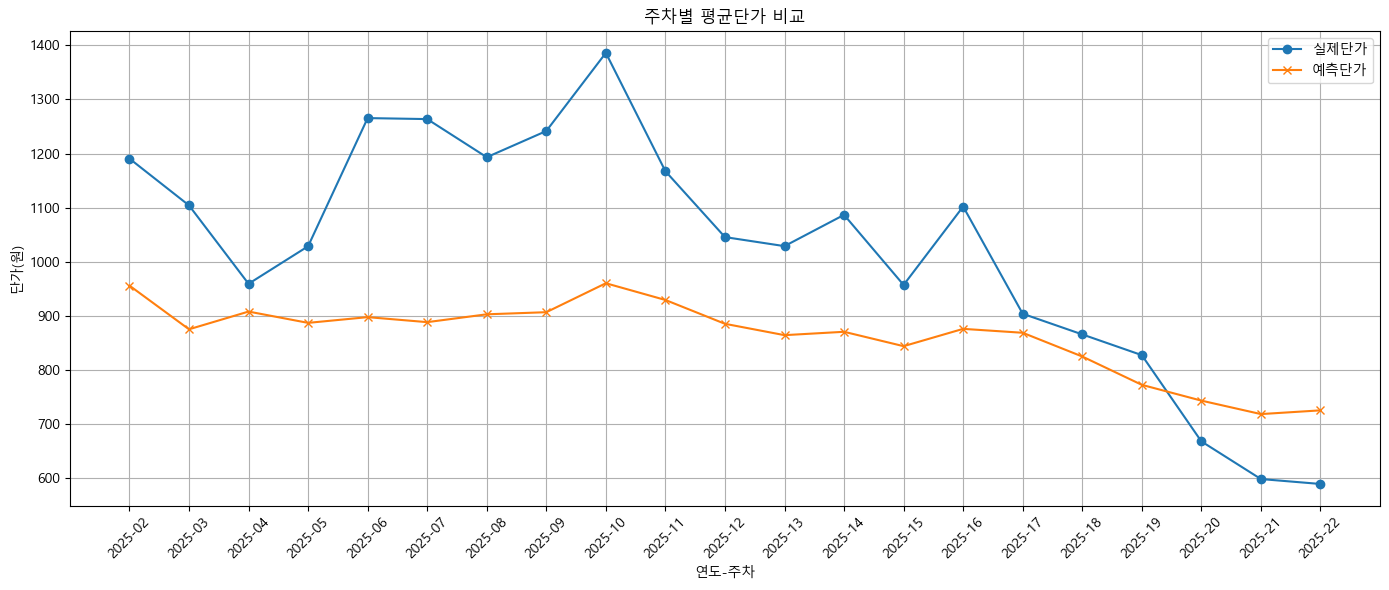

In [28]:
# 1. 예측 결과와 실제값 결합
df_result = pd.DataFrame({
    'index': y_test.index,
    '실제단가': y_test.values,
    '예측단가': pred
})

# 2. 원본 df에서 'year', 'week' 컬럼만 추출해서 join
df_meta = df[['year', 'week']].reset_index()  # 원본 df에서 날짜 정보 추출
df_result = df_result.merge(df_meta, how='left', on='index')  # index 기준으로 날짜 정보 병합

# 3. 주차별 평균 계산
df_weekly = df_result.groupby(['year', 'week'])[['실제단가', '예측단가']].mean().reset_index()
# 1. year와 week를 문자열로 붙인 새 컬럼 생성 (예: '2025-01')
df_weekly['연도주차'] = df_weekly['year'].astype(str) + '-' + df_weekly['week'].astype(str).str.zfill(2)


# 4. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_weekly['연도주차'], df_weekly['실제단가'], label='실제단가', marker='o')
plt.plot(df_weekly['연도주차'], df_weekly['예측단가'], label='예측단가', marker='x')
plt.title('주차별 평균단가 비교')
plt.xlabel('연도-주차')
plt.ylabel('단가(원)')
plt.xticks(rotation=45)  # x축 라벨이 겹치지 않도록 회전
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()